# Preprocessing
melakukan preprocess data terutama untuk attribut `content` setelah dilakukannya proses EDA. dilakukannya tahapan ini bertujuan untuk membersihkan data sehingga data siap digunakan untuk di proses berikutnya.

In [1]:
# Library yang digunakan pada tahapan preprocessing
import pandas as pd, re, os, string
import nlp_id

# NLP areas
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# utility
import matplotlib.pyplot as plt
from pathlib import Path
from wordcloud import WordCloud

#### Membaca Data hasil dari proses sebelumnya

In [2]:
data = pd.read_csv('../out/00-result-eda.tsv', sep='\t')

## Membuat Function untuk preprocessing
preprocessing yang dilakukan diantaranya: 
- mention extraction
- case folding -> cleaning -> tokenizing -> stopword removal -> stemming

In [3]:
# class untuk menggabungkan corpus stopwords dari library nltk, nlp-id, dan tambahan lainnya
# dengan mewarisi dari class Stopword miliki library nlp-id
class StopWord(nlp_id.StopWord):
    def __init__(self, stopword_path=None):
        self.current_dir = Path(os.path.dirname(os.path.realpath(__name__)))

        if not stopword_path:
            stopword_path = os.path.join(self.current_dir.parent.absolute(), "data", "00-stopwords")
        super(StopWord, self).__init__()
        
        nltk_stopwords = set(stopwords.words('indonesian'))
        self.stopwords = set(self.stopwords).union(nltk_stopwords)
        del nltk_stopwords

        with open(stopword_path) as f:
            additional = f.read().split('\n')
            self.stopwords = set(self.stopwords).union(set(additional))

In [19]:
class Preprocessing:
    def __init__(self):
        self.stopword = StopWord()
        self.stemmer = StemmerFactory().create_stemmer()
        self.tokenizer = nlp_id.Tokenizer()
        
    def preprocessing(self, text):
        text = self.case_folding(text)
        text = self.cleaning(text)
        text = self.remove_stopword(text)
        text = self.stemming(text)
        return text.split(" ")

    def case_folding(self, text):
        return text.lower()

    def cleaning(self, text):
        cleaned_content = re.sub(r'https?://\S+|www\.\S+', ' ', text)
        cleaned_content = re.sub(r'[^a-zA-Z\s]', ' ', cleaned_content)
        return cleaned_content.translate(str.maketrans('', '', string.punctuation))

    def remove_stopword(self, text):
        return ' '.join([word for word in text.split() if word not in self.stopword.stopwords])

    def stemming(self, text):
        return ' '.join([self.stemmer.stem(word) for word in text.split()])

In [20]:
utils = Preprocessing()

## Melakukan Preprocessing pada data
- attribut `content` dirubah menjadi `raw_content` dan `content` yang sudah dilakukan preprocessing diberi nama attribut `cleaned_content`
- mention yang diextract dimasukan ke dalam attribut `mentioned`

In [21]:
data.rename(columns={'content':'raw_content'}, inplace=True)
data['cleaned_content'] = data['raw_content'].apply(lambda x: utils.preprocessing(x))

In [22]:
data['mentioned'] = data['raw_content'].apply(lambda x: re.findall(r'@(\w+)', x))

In [23]:
data.head(5)

,raw_content,username,tweet_published_at,type,cleaned_content,mentioned
0,Gak sabar nonton coldplay 🥹🥲 @woootamelon semo...,LSuroyaa,2023-05-02 06:42:14+07,tweet,"[gak, sabar, nonton, coldplay, woootamelon, mo...",[woootamelon]
1,@jn_jiu @mistamosby Ga suka coldplay 😭😭😭,COMRADE_SOLAR,2023-05-04 00:07:38+07,replied_to,"[jn, jiu, mistamosby, ga, suka, coldplay]","[jn_jiu, mistamosby]"
2,"Huhu ada lagiii, HALOOO @coldplay https://t.co...",bekstreettt,2023-05-05 12:46:14+07,replied_to,"[huhu, lagiii, halooo, coldplay]",[coldplay]
3,Salah satu tanda @coldplay ke Indonesia untuk ...,SeleccionINA,2023-05-07 10:42:19+07,tweet,"[salah, tanda, coldplay, indonesia, tur, dunia...","[coldplay, coldplay]"
4,@IDWantsColdplay @coldplay Bismillah menang wa...,finyjr,2023-05-08 23:02:38+07,replied_to,"[idwantscoldplay, coldplay, bismillah, menang,...","[IDWantsColdplay, coldplay]"


## Mengecek frequensi kata yang muncul menggunakan wordcloud

In [24]:
freqs = {}
for x in data['cleaned_content'].iloc:
  for word in x:
    count = freqs.get(word, 0)
    freqs[word] = count + 1

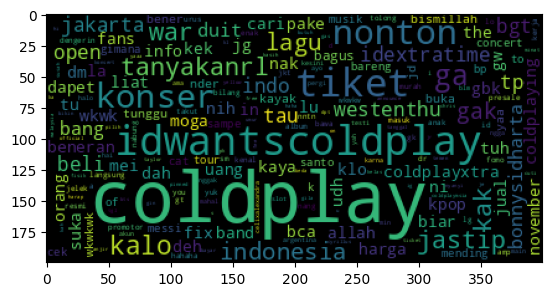

In [25]:
plt.imshow(WordCloud().generate_from_frequencies(freqs))

## Export Data

In [26]:
data_output = data.copy(deep=True)

In [27]:
data_output.to_csv('../out/01-preprocessing.tsv', sep="\t", index=False)